<a href="https://www.kaggle.com/code/davidjohnmillard/tfwriter-rsna?scriptVersionId=116298583" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# RSNA TFWriter

The following is an approach to writing TFRecords to a Bucket in GCS.

# Imports/Setup

In [1]:
!pip install python-gdcm -q
!pip install pylibjpeg -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import os
import cv2
import tensorflow as tf
from google.cloud import storage

In [3]:
path_test = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
path_train = '/kaggle/input/rsna-breast-cancer-detection/train.csv'

In [4]:
dfte = pd.read_csv(path_test)
dftr = pd.read_csv(path_train)

# Handle the Data

First we need to split the training data into a training and validation set.

To get the image paths we can apply a function to the dataframe on each row to get the picture with patient_id and image_id.

Next we do some basic preproccessing to make sure each image is normalized.

In [5]:
def train_test_split(dataset):
    split = int(dataset.shape[0] * .8)
    return dataset[:split], dataset[split:]

In [6]:
def add_img_path_to_pd(row):
    return '/kaggle/input/rsna-breast-cancer-detection/train_images/' + str(row['patient_id']) + '/' + str(row['image_id']) + '.dcm'

# Image ROI



In [7]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


Normalize the data and clip the data to inlcude only between 5 < x < 99 percentile of data.

In [8]:
def truncation_normalization(img):
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img, Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized

Use CLAHE to clip the image at certain thresholds of contrast. 
> clipLimit -> Threshold for contrast limiting

In [9]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [10]:
def preprocess(imagepath):
    IMG_SIZE = 1024
    ds = pydicom.dcmread(imagepath)
    img = ds.pixel_array
    
    img_max = np.max(img)
    img = img / np.max(img)
    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img = img * img_max
    img = img[..., tf.newaxis]
    
    (x, y, w, h) = crop_coords(img.astype("uint8"))
    img_cropped = img[y:y+h, x:x+w]
    
    img_normalized = truncation_normalization(img_cropped)
                                              
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))
                                              
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
                                              
    return (img_final / np.max(img_final)).astype('float32')

In [11]:
img = tf.io.serialize_tensor(preprocess('/kaggle/input/rsna-breast-cancer-detection/train_images/10025/893612858.dcm')).numpy()

2023-01-13 22:22:36.806696: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
image = tf.io.parse_tensor(img, out_type=tf.float32)

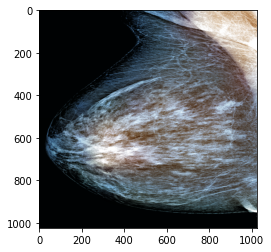

In [13]:
plt.imshow(image)

# Useful Stats Writing Data

This is not a EDA Notebook book but we do need some useful statistics to deal with data.

In [14]:
def useful_stats():
    print('pos train %: ' + str(dftr[dftr['cancer'] == 1].shape[0] / dftr.shape[0] * 100))
    print('pos valid %: ' + str(dfv[dfv['cancer'] == 1].shape[0] / dfv.shape[0] * 100))

# Dealing With Files locally and in the Cloud

We need to follow the sequence: 
> write to local file -> push to cloud -> delete from local -> repeat

In [15]:
def push_to_cloud(filepath, bucket_name):
    print('pushing ' + filepath + ' to cloud in bucket: train_batches')
    
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(filepath)
    blob.upload_from_filename('/kaggle/working/' + filepath)

In [16]:
def delete_file(filepath):
    print('deleting ' + filepath + ' from local')
    os.remove('/kaggle/working/' + filepath)
    
def clear_all_local():
    for k in os.listdir('/kaggle/working/'):
        if k == '.virtual_documents':
            continue
        delete_file(k)

# Create an Example

Create an example using the features necessary to the Network.

In [17]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

def get_example(image, label, age, implant, laterality, view, diff_neg):
    return Example(
        features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(image).numpy()])),
                'label': Feature(int64_list=Int64List(value=[label])),
                'age': Feature(int64_list=Int64List(value=[age])),
                'impant': Feature(int64_list=Int64List(value=[implant])),
                'laterality': Feature(bytes_list=BytesList(value=[laterality])),
                'view': Feature(bytes_list=BytesList(value=[view])),
                'diff_neg': Feature(int64_list=Int64List(value=[diff_neg]))
            }
        )
    )

# Write TFRecords

To write the files we need the dataset to read from, the name of the batches we are writing, and the bucket to write to.

The dataest is split into n batches and use offset incase connection is lost.

For every file in the n files created we create an example using the corresponding instance's values in the dataframe.

Finally the example is serialized and written it to the file.

This file is then pushed to gcs and deleted from the local system.

In [18]:
def write_tfrecords(name, dataset, bucket_name, n_shards=15, offset=0):
    paths = ["{}_batch_{}.tfrecord".format(name, index) for index in range(offset, n_shards)]
    
    for num, i in enumerate(paths):
        with tf.io.TFRecordWriter(i) as f: 
            print('writing to ' + i )
            for index, row in dataset[(num+offset)*(int(dataset.shape[0] / n_shards) + 1):(num+offset+1)*(int(dataset.shape[0] / n_shards) + 1)].iterrows():
                image = preprocess(row['imagepath'])
                label = row['cancer']
                age = int(row['age'])
                implant = row['implant']
                laterality = bytes(row['laterality'], 'utf-8')
                view = bytes(row['view'], 'utf-8')
                diff_neg = 1 if row['difficult_negative_case'] else 0
                example = get_example(image, label, age, implant, laterality, view, diff_neg)
                f.write(example.SerializeToString())
                
        push_to_cloud(i, bucket_name)
        delete_file(i)
            
    return paths

# Define GCS Storage Area

In [19]:
client_area = 'kagglersna01'
storage_client = storage.Client(project=client_area)

# Apply Transformation to DataFrame

In [20]:
def setup_data(dirr, dataset):
    dataset.fillna(dataset['age'].median(), inplace=True)
    dataset['imagepath'] = dataset.apply(add_img_path_to_pd, axis=1)
    return train_test_split(dataset)
dftr, dfv = setup_data('train_images', dftr)

In [21]:
useful_stats()

pos train %: 2.0770496298327394
pos valid %: 2.2756351672454764


# Run TFRecord Writer

In [22]:
def main_run(name, dataset, bucket_name):
    clear_all_local()
    write_tfrecords(name, dataset, bucket_name, int(dataset.shape[0] / 15) + 1, offset=0)

In [23]:
BUCKET_NAME = 'train_batches'
# main_run('valid', dfv, BUCKET_NAME)

# Parse an Example Instance

In [24]:
def parse_example(tfrecord):
    feature_desc = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'age': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'impant': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'laterality': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'view': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'diff_neg': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    example = tf.io.parse_single_example(tfrecord, feature_desc)
    image = tf.io.parse_tensor(example["image"], out_type=tf.float32)
    image = tf.reshape(image, shape=[1024, 1024])
    return image, example["label"], example['laterality']

# Get Dataset From GCS Files

Create a tf.dataset from the file names in gcs.

We use multi-threading to speed up processing time.

We also shuffle the dataset to add more variablility. 

We call dataset.map() to parse each example in the file.

In [25]:
def record_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=32, n_parse_threads=5, batch_size=32):
    
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_example, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(32)
    
    return dataset.prefetch(1)

In [26]:
trainpaths = ['gs://' + BUCKET_NAME + '/' + "{}_batch_{}.tfrecord".format('train', index) for index in range(15)]
validpaths = ['gs://' + BUCKET_NAME + '/' + "{}_batch_{}.tfrecord".format('valid', index) for index in range(15)]

train_set = record_dataset(trainpaths)
validset = record_dataset(validpaths)

In [27]:
def init_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() 

    print("REPLICAS: ", strategy.num_replicas_in_sync)